In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn  as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
torch.manual_seed(42)

In [6]:
df = pd.read_csv('data/fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


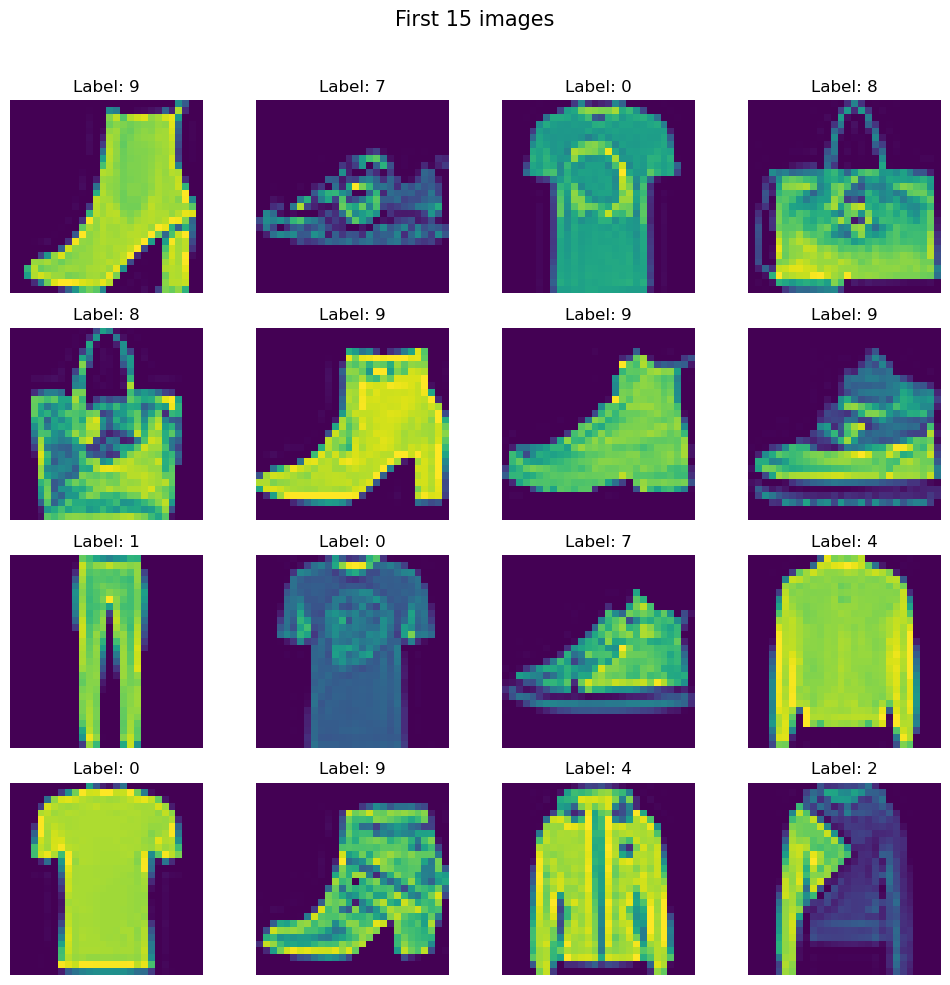

In [8]:
# create a 4x4 grid of images
fig, axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 15 images",fontsize=15)

for i ,ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()
    

In [9]:
# train test split

X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
X_train.shape

(4800, 784)

In [12]:
X_train = X_train/255.0
X_test = X_test/255.0

In [13]:
X_train

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.0627451, 0.       ,
        0.       ]], shape=(4800, 784))

In [14]:
# class CustomDataset Class
class CustomDataset(Dataset):
    def __init__(self,features,labels):
        self.features = torch.tensor(features,dtype=torch.float32)
        self.labels = torch.tensor(labels,dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,index):
        return self.features[index] , self.labels[index]


In [15]:
# create train_dataset object
train_dataset = CustomDataset(X_train,y_train)

In [17]:
# create test dataset object
test_dataset = CustomDataset(X_test,y_test)

In [18]:
# create train and test loader
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [22]:
# define the NN class

class MyNN(nn.Module):
    def __init__(self,num_features):

        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(num_features,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )

    def forward(self,x):

        return self.model(x)

In [23]:
# set learning rate and epochs

epochs = 100
learning_rate = 0.1

In [24]:
# initiate the model

model = MyNN(num_features=X_train.shape[1])

# loss function

criterion = nn.CrossEntropyLoss()

#optimizer 
optimizer = optim.SGD(model.parameters(),lr = learning_rate)

In [25]:
len(train_loader)

150

In [26]:
# training Loop

for epoch in range(epochs):

    total_epoch_loss = 0
    for batch_features,batch_labels in train_loader:

        # forward pass
        outputs = model(batch_features)

        # calculate loss
        loss = criterion(outputs,batch_labels)


        # back pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()

        total_epoch_loss = total_epoch_loss + loss.item()

    
    print(f"epoch {epoch+1} loss {total_epoch_loss/len(train_loader)}")
    print("_"*50)



epoch 1 loss 1.3216368520259858
__________________________________________________
epoch 2 loss 0.7793365434805553
__________________________________________________
epoch 3 loss 0.6427524582544962
__________________________________________________
epoch 4 loss 0.5751657412449519
__________________________________________________
epoch 5 loss 0.5281801844636599
__________________________________________________
epoch 6 loss 0.49528749744097395
__________________________________________________
epoch 7 loss 0.46024330735206603
__________________________________________________
epoch 8 loss 0.4359459040562312
__________________________________________________
epoch 9 loss 0.4182921407620112
__________________________________________________
epoch 10 loss 0.39840922340750695
__________________________________________________
epoch 11 loss 0.38502645343542097
__________________________________________________
epoch 12 loss 0.37226854960123695
_______________________________________________

In [27]:
# set model to eval
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [28]:
len(test_loader)

38

In [29]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():
    for batch_features,batch_labels in test_loader:
        outputs = model(batch_features)

        _, predicted = torch.max(outputs,1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted == batch_labels).sum().item()
    
    print(correct/total)


0.82
